In [1]:
import numpy as np

import pandas as pd

import seaborn as sns
import  matplotlib.pyplot as plt

from lib.mcalc import gcf2ann, spike2bin, spikeCoin
from lib.mviz import visSpk

### Trial-by-trial variability

In [6]:
# data setting
D = 2.0
recpath = './data/var-D%.1f'%D
Nm = 5000

epoch = 10
T, dt = 2500, 0.1
Nfs = np.array([0, 30, 40, 50, 60,  100, 200, 300])
Ws = np.array([0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5])

extract = True

In [5]:
Nf = 50
W = 0.01

label = '/Nf%d-W%s/'%(Nf, W)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

colors = ['green', 'blue', 'red']
# colors = ['blue']

plt.figure(figsize=(10, 5))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)
    plt.scatter(ts[idx]-ta, es[idx], s=1, c=c)
    plt.xlim(0, 500)
plt.show()

if Nf > 0:
    nNums = [Nm, Nf]
else:
    nNums = [Nm, 1]
    
binsize = 5

plt.figure(figsize=(10, 5))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=Nm)

    idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
    tmBins = np.arange(0, T+1-500, binsize)
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] / binsize * 1000 / nNums
    
    plt.plot(rates[:,0], c=c)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './data/var-D2.0/Nf50-W0.002/spk.npz'

In [11]:
if extract:
    #  extract data from raw recordings
    frames = []
    binsize = 5
    for Nf in Nfs:
        if Nf > 0:
            nNums = [Nm, Nf]
        else:
            nNums = [Nm, 1]
        for W in Ws:
            label = '/Nf%d-W%s/'%(Nf, W)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # processing data
            rates = []
            for e in np.arange(0, epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

                idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0])
            rates = np.array(rates)[:,:,0]
            
            # Correlation
            fanos = rates.var(axis=0)/rates.mean(axis=0)
            fano = np.mean(fanos[~np.isnan(fanos)])

            # correlation
            cors = np.corrcoef(rates)
            corr = (np.sum(cors)-np.trace(cors))/cors.shape[0]/(cors.shape[0]-1)

            frames.append([Nf, W, np.mean(rates*1e3/Nm/binsize), fano, corr])

    colname = ['Nf', 'Win', 'rout', 'Fano', 'Corr']
    stats = pd.DataFrame(np.array(frames), columns=colname)

    np.savez('./exp/var/stats-D%.1f.npz'%D, np.array(frames))
    stats.to_csv('./exp/var/stats-D%.1f.csv'%D)

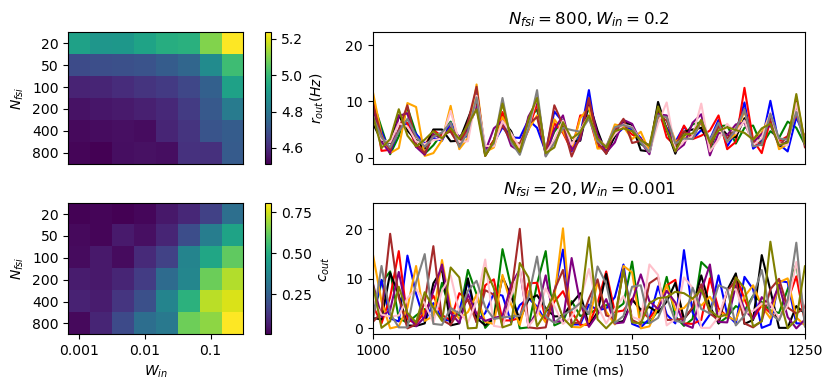

In [47]:
# load extracted data
stats = pd.read_csv('./exp/var/stats-D%.1f.csv'%D)
corrs = stats['Corr'].to_numpy()
rates = stats['rout'].to_numpy()
fig_corr = np.reshape(corrs, newshape=(len(Nfs), len(Ws)));
fig_rate = np.reshape(rates, newshape=(len(Nfs), len(Ws)));

# plot
# plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(2,2,figsize=(10,4), width_ratios=[1,1])

# ax = axes[0,0]
# ax.plot(Nfs, fig_corr[:,0], 'o-', label=r'$r_{in}=0Hz$')
# ax.set_xlabel(r'$N_{fsi}$')
# ax.set_ylabel('Across-trial Correlation')
# ax.legend(loc='upper right')

# ax = axes[0,0]
# ax.plot(Ws[1:], fig_corr[0,1:], 'o-', label=r'$N_{fsi}=0$')
# ax.set_xlabel(r'$W_{in}$')
# ax.set_ylabel('Across-trial Correlation')
# ax.legend(loc='lower right')

ax = axes[0,0]
im = ax.imshow(fig_rate[np.ix_(np.arange(len(Nfs)-1)+1, np.arange(len(Ws)-1)+1)])
# ax.set_xlabel(r'$W_{in}$')
# ax.set_xticks(np.arange(len(Ws)-1), Ws[1:]);
ax.set_xticks([])
ax.set_ylabel(r'$N_{fsi}$')
ax.set_yticks(np.arange(len(Nfs)-1), Nfs[1:]);
cbar = plt.colorbar(im, fraction=0.046)
cbar.set_label(r'$r_{out}(Hz)$')

idx = np.array([1, 4, 7])
ax = axes[1,0]
im = ax.imshow(fig_corr[np.ix_(np.arange(len(Nfs)-1)+1, np.arange(len(Ws)-1)+1)])
ax.set_xlabel(r'$W_{in}$')
ax.set_xticks(idx-1, Ws[idx]);
ax.set_ylabel(r'$N_{fsi}$')
ax.set_yticks(np.arange(len(Nfs)-1), Nfs[1:]);
cbar = plt.colorbar(im, fraction=0.046)
cbar.set_label(r'$c_{out}$')

Nf = 800
W = 0.2

label = '/Nf%d-W%s/'%(Nf, W)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

colors = ['green', 'blue', 'red', 'black', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
# colors = ['blue', 'red']

idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
tmBins = np.arange(0, T+1-500, binsize)

ax = axes[0,1]
ax.set_title(r'$N_{fsi}=%d, W_{in}=%s$'%(Nf, W))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=Nm)
    
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize
    rates = rates/nNums

    tms = tmBins[:-1]
    ax.plot(tms, rates[:,0], c=c)
ax.set_xlim([1000, 1250])
ax.set_xticks([])

Nf = 20
W = 0.001

label = '/Nf%d-W%s/'%(Nf, W)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

ax = axes[1,1]
ax.set_title(r'$N_{fsi}=%d, W_{in}=%s$'%(Nf, W))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=Nm)

    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize
    rates = rates/nNums

    tms = tmBins[:-1]
    ax.plot(tms, rates[:,0], c=c)
ax.set_xlim([1000, 1250])
ax.set_xlabel('Time (ms)')

plt.tight_layout()
plt.savefig('./plot/var.pdf', transparent=True, bbox_inches='tight', dpi=500)

### Temporal correlation

In [3]:
# data setting
Ss = [2.0, 5.0, 10.0, 15.0, 20.0]
Ds = [1.0, 2.0, 3.0]
D = Ds[-1]
recpath = './data/cor-D%.1f'%D
Nm = 1000

epoch = 10
T, dt = 2500, 0.1

Nfs = np.array([0, 20, 50, 100, 200, 400, 800])
Ws = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])
Bs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
Nf = 20
W = 0.01
B = 0.5

label = '/Nf%d-W%s-B%s/'%(Nf, W, B)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

# colors = ['green']
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

plt.figure(figsize=(10, 5))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)
    plt.scatter(ts[idx]-ta, es[idx], s=1, c=c)
    plt.xlim(500, 1500)
plt.show()

nNums = [Nm, Nm, Nf]  
binsize = 20

plt.figure(figsize=(10, 5))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

    idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
    tmBins = np.arange(0, T+1-500, binsize)
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0] * 1e3 / binsize
    rates = rates/nNums
    
    tms = tmBins[:-1] + e*T
    plt.plot(tms, rates[:,0], 'b')
    plt.plot(tms, rates[:,1], 'r')
plt.show()

In [ ]:
# extract data from raw recordings
frames = []
binKernel = np.ones(int(5 / dt))
grpsize = 100
binsize = 5
for Nf in Nfs:
    if Nf > 0:
        nNums = [Nm, Nm, Nf]
    else:
        nNums = [Nm, Nm, 1]
    for W in Ws:
        for B in Bs:
            label = '/Nf%d-W%s-B%s/'%(Nf, W, B)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # spikes
            mask = (es > Nm-100) & (es <= Nm+100) & (ts < T*3)
            visSpk(ts[mask], es[mask]-Nm+100, path='./plot/cor-D%.1f'%D + label + 'spk/spk')

            # processing data
            rates = []
            corrs = []
            for e in range(epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

                idBins = np.arange(1, 2*Nm+2, grpsize)
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0]*1e3/binsize/grpsize)

                coV = np.corrcoef(rates[-1].T)
                np.fill_diagonal(coV, 0.)

                ng = int(Nm/grpsize)
                ix = np.arange(0, ng)
                corrs.append([   (np.sum(coV[np.ix_(ix, ix)])/ng/(ng-1) + np.sum(coV[np.ix_(ix+ng, ix+ng)])/ng/(ng-1))/2,
                                np.sum(coV[np.ix_(ix, ix+ng)])/ng/ng])

            # output correlations
            corrs = np.array(corrs)
            frames.append([Nf, W, B, corrs[:,0].tolist(), corrs[:,1].tolist()])

colname = ['Nf', 'Win', 'Bin', 'Wout', 'Bout']
stats = pd.DataFrame(frames, columns=colname)
stats.to_csv('./exp/cor/stats-D%.1f.csv'%D, index=False)

(10, 99) (10, 99)


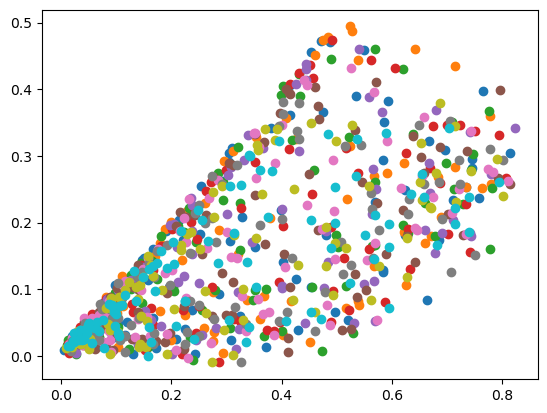

In [4]:
stats = pd.read_csv('./exp/cor/stats-D%.1f.csv'%D)

import ast
def string_to_np_array(string):
    return np.array(ast.literal_eval(string))
stats['Wout'] = stats['Wout'].apply(string_to_np_array)
stats['Bout'] = stats['Bout'].apply(string_to_np_array)

cors = stats[['Nf', 'Wout', 'Bout']]
va = 0
wa, ba = cors.loc[cors['Nf']==va, 'Wout'], cors.loc[cors['Nf']==va, 'Bout']
wa = np.stack(wa).transpose()
ba = np.stack(ba).transpose()
print(wa.shape, ba.shape)
for i in range(wa.shape[0]):
    plt.scatter(wa[i], ba[i], marker='o', label=r'$N_{fsi}=0$')

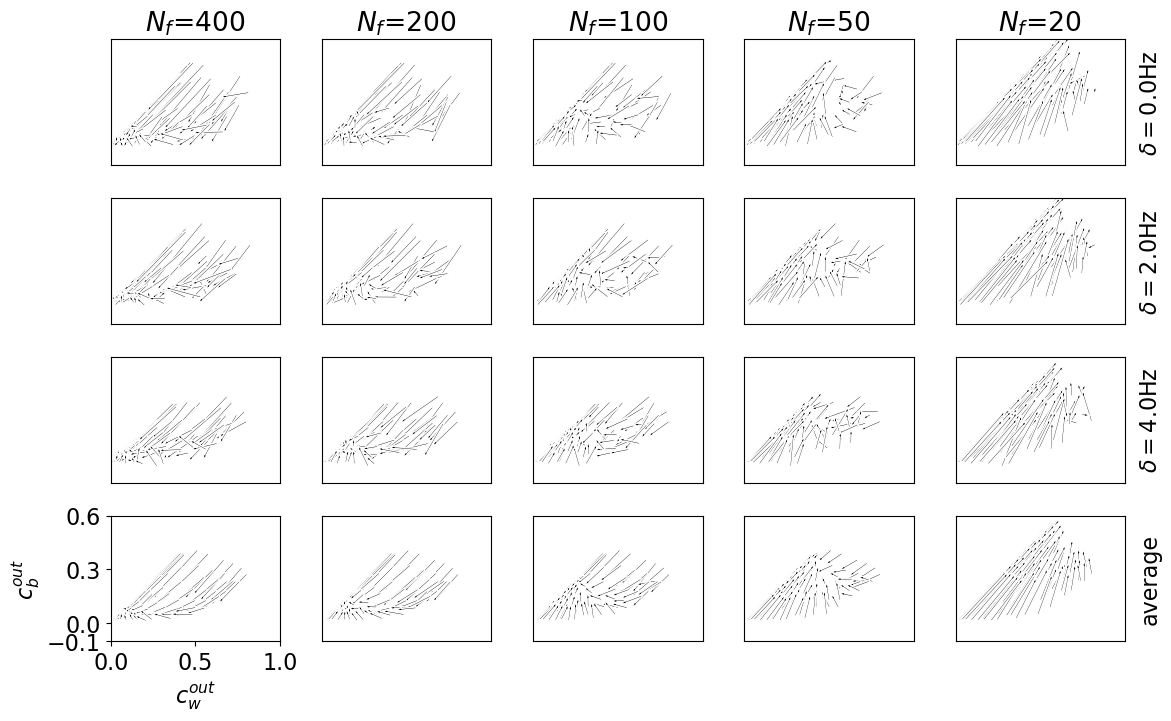

In [11]:
# plot font size
# plt.rcParams.update({'font.size': 16})

Nfsl = [400, 200, 100, 50, 20]
eps = [0, 4, 8]

fig,axes = plt.subplots(len(eps)+1, len(Nfsl), figsize=(3*(len(Nfsl)-1), 2.5*len(eps)))

for j, vb in enumerate(Nfsl):
    wb, bb = cors.loc[cors['Nf']==vb, 'Wout'], cors.loc[cors['Nf']==vb, 'Bout']
    wb = np.stack(wb).transpose()
    bb = np.stack(bb).transpose()

    for i, idx in enumerate(eps):
        ax = axes[i,j]
        if i == 0:
            ax.set_title(r'$N_f$=%d'%vb)
        
        # axis label
        if j == len(Nfsl)-1:
            ax.yaxis.set_label_position("right")
            ax.yaxis.labelpad = 10
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel(r'$\delta=$%.1fHz'%(idx*0.5))
        else:
            ax.set_yticks([])
        ax.set_xticks([])

        # xy range
        ax.set_xlim(0, 1.0)
        ax.set_ylim(-0.1, 0.6)

        # plot
        for x, y, xx, yy in zip(wa[idx], ba[idx], wb[idx], bb[idx]):
            ax.arrow(x, y, xx-x, yy-y, width=0.01, head_width=0.02, edgecolor='w', facecolor='k', alpha=1.0);

    ax = axes[len(eps), j]
    for x, y, xx, yy in zip(np.mean(wa,axis=0), np.mean(ba,axis=0), np.mean(wb,axis=0), np.mean(bb,axis=0)):
        ax.arrow(x, y, xx-x, yy-y, width=0.01, head_width=0.02, edgecolor='w', facecolor='k', alpha=1.0);
    # xy range
    ax.set_xlim(0, 1.0)
    ax.set_ylim(-0.1, 0.6)
    if j == 0:
        ax.set_xlabel(r'$c_w^{out}$') 
        ax.set_ylabel(r'$c_b^{out}$')
        ax.set_xticks([0, 0.5, 1.0])
        ax.set_yticks([-0.1, 0., 0.3, 0.6])
    elif j == len(Nfsl)-1:
        ax.yaxis.set_label_position("right")
        ax.yaxis.labelpad = 10
        ax.yaxis.tick_right()
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('average')
    elif j > 0:
        ax.set_yticks([])
        ax.set_xticks([])
    
plt.tight_layout()
plt.savefig('./plot/cor.pdf', bbox_inches='tight')